http://twiecki.github.io/blog/2015/11/10/mcmc-sampling/

In [124]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm

sns.set_style('white')
sns.set_context('talk')

np.random.seed(123)

In [125]:
data = np.random.randn(20)

In [126]:
data

array([-1.0856306 ,  0.99734545,  0.2829785 , -1.50629471, -0.57860025,
        1.65143654, -2.42667924, -0.42891263,  1.26593626, -0.8667404 ,
       -0.67888615, -0.09470897,  1.49138963, -0.638902  , -0.44398196,
       -0.43435128,  2.20593008,  2.18678609,  1.0040539 ,  0.3861864 ])

c:\users\scott clay\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


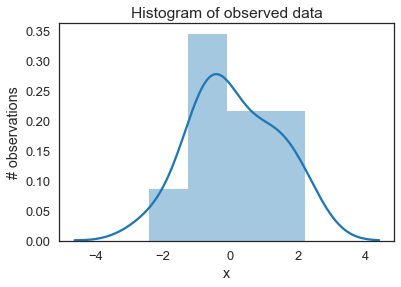

In [127]:
ax = plt.subplot()
sns.distplot(data, kde=True, ax=ax)
_ = ax.set(title='Histogram of observed data', xlabel='x', ylabel='# observations')

In [128]:
data.mean()

0.11441773195529023

In [108]:
def calc_posterior_analytical(data,x,mu_0,sigma_0):
    sigma = 1.
    n = len(data)
    mu_post = (mu_0/sigma_0**2 + data.sum() / sigma**2) / (1.0 / sigma_0**2 + n/sigma**2)
    sigma_post = (1.0 / sigma_0**2 + n/sigma**2)**-1
    return norm(mu_post, np.sqrt(sigma_post)).pdf(x), mu_post, sigma_post

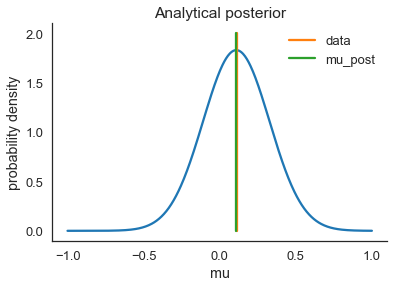

In [129]:
ax = plt.subplot()
x = np.linspace(-1,1,500)
posterior_analytical, mu_post, sigma_post = calc_posterior_analytical(data,x,0.,1.)
ax.plot(x,posterior_analytical)
ax.plot([data.mean(),data.mean()],[0,2.0], label = 'data')
ax.plot([mu_post,mu_post],[0.0,2.0], label = 'mu_post')
ax.set(xlabel='mu', ylabel='probability density', title='Analytical posterior')
ax.legend()
sns.despine()

In [103]:
data.mean(), data.var(), data.std()

(0.11441773195529023, 1.5021278845126171, 1.2256132687404364)

In [104]:
x.mean(), x.var(), x.std()

(-8.526512829121202e-17, 0.33466933867735466, 0.5785061267414154)

In [105]:
mu_post, sigma_post

(0.10896926852884785, 0.047619047619047616)

The posterior mean is calculated from the original data (data) and the new evidence (x) based on their means and variances. The variance is used to determine which is more strongly believed in the calculation of the posterior mean. 

In this case, you can see how the datas variance was quite large, where as the new x wasn't, hence the posterior mean shifted back towards zero from the data mean. 

Note that the posterior mean is a weighted average of the prior mean and the new data mean. The weight on the prior mean is inversely proportional to the variance of the prior mean, and the weight on the new data (x) is inversly prop to the variance of the new data mean. Thus, if the prior mean is very precise relative to the new data mean, then we should weigh it higher. And vice versa. Combining both the prior and new data information gives us a more precise esitmate than if we used either source indepentenly. 